## Introduction

`Name  : Ari Riscahyo Nugroho`

`Batch : 007`

`Github: Ari2109`

This notebook used the bank dataset here: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

This notebook aims to explore the dataset briefly and tried to make models which predicts if the person will subscribe a term deposit or not. There are 7 models introduced here, they are Logistic Regression, SVM, Decision Tree, Random Forest, kNN, Naive Bayes, and lastly LightGBM

## Import Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

In [2]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [3]:
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
30019,23,admin.,single,university.degree,no,yes,no,cellular,apr,wed,621,1,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,yes
3481,46,admin.,single,high.school,no,no,no,telephone,may,thu,78,4,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
12306,32,blue-collar,married,basic.6y,no,yes,no,telephone,jul,fri,133,1,999,0,nonexistent,1.4,93.918,-42.7,4.959,5228.1,no
34853,36,admin.,single,high.school,no,yes,yes,cellular,may,fri,10,5,999,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1,no
13416,34,admin.,married,university.degree,no,no,no,cellular,jul,wed,266,1,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no


Before we continue, here is the data description by the data provider: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

Important note to take:
1. Call duration highly impact the model outcome (example duration = 0  will lead to 'No'), yet there's no way to know about it until the call ended, and by the time the call ended, we already know about the result, so this needs to be discarded if we want to build it realistically
2. As such, we will discard that column immediately. This model will assume that user will not input duration data. 
3. Note that in some columns, there are value such as 'unknown', 'nonexistent', and 999. We can safely assume that the missing data is already handled in this way

In [4]:
df.drop(columns='duration', inplace=True)

## EDA

In [5]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

This confirms the assumption, we are good with no missing data need to be handled

Now, let's check the data distribution

In [49]:
df.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f28aef2ee50>,
      dtype=object)

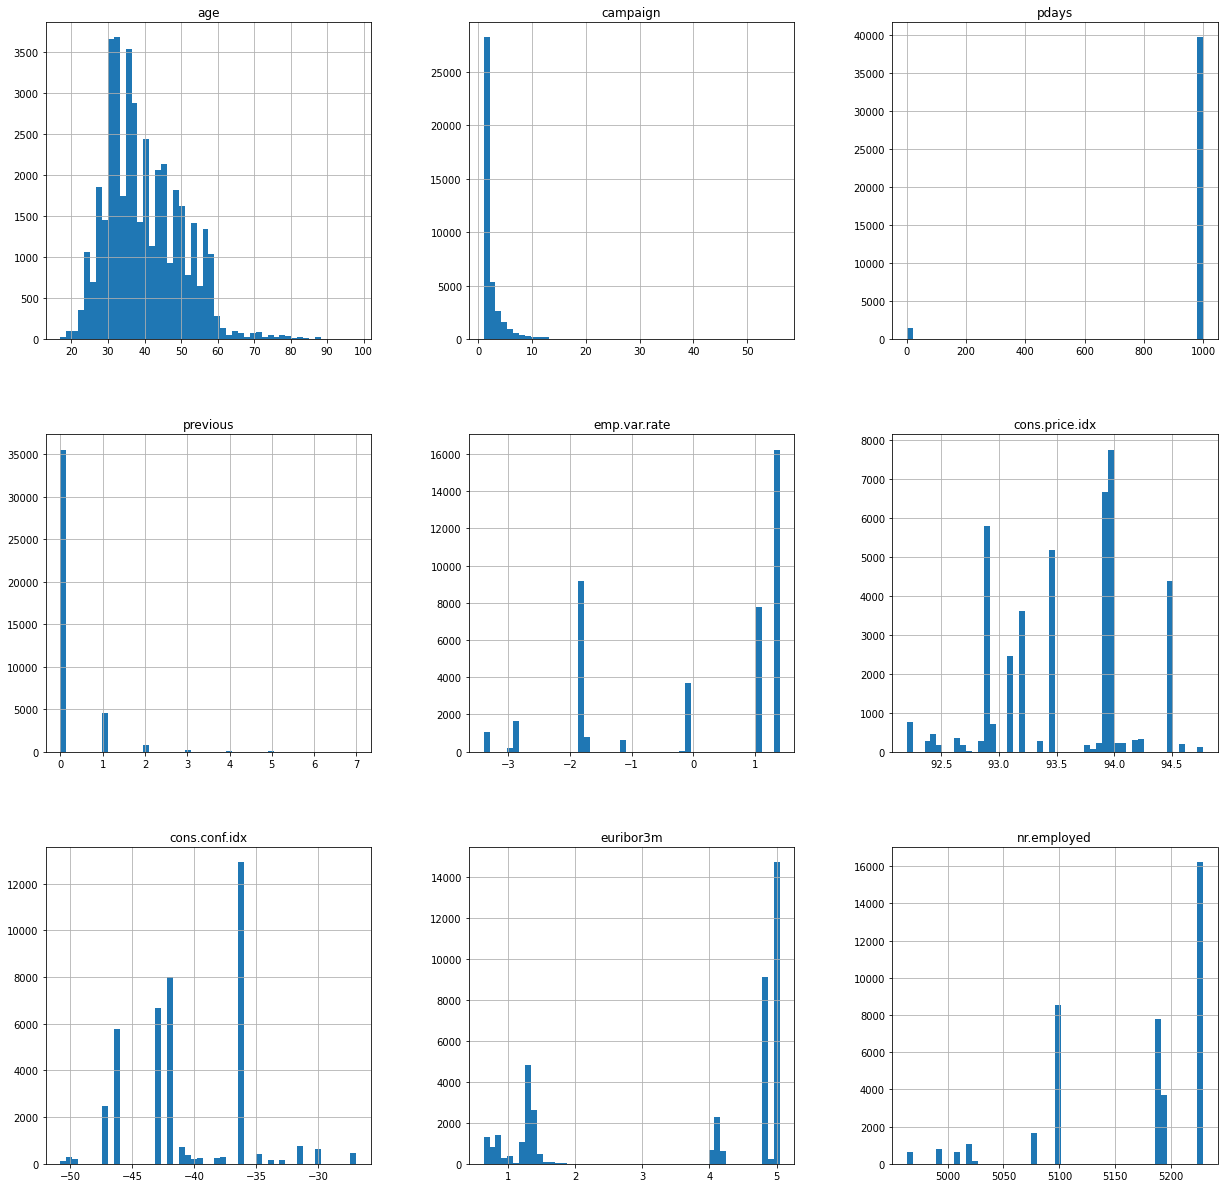

In [8]:
df.hist(bins=50, figsize=(21,21))

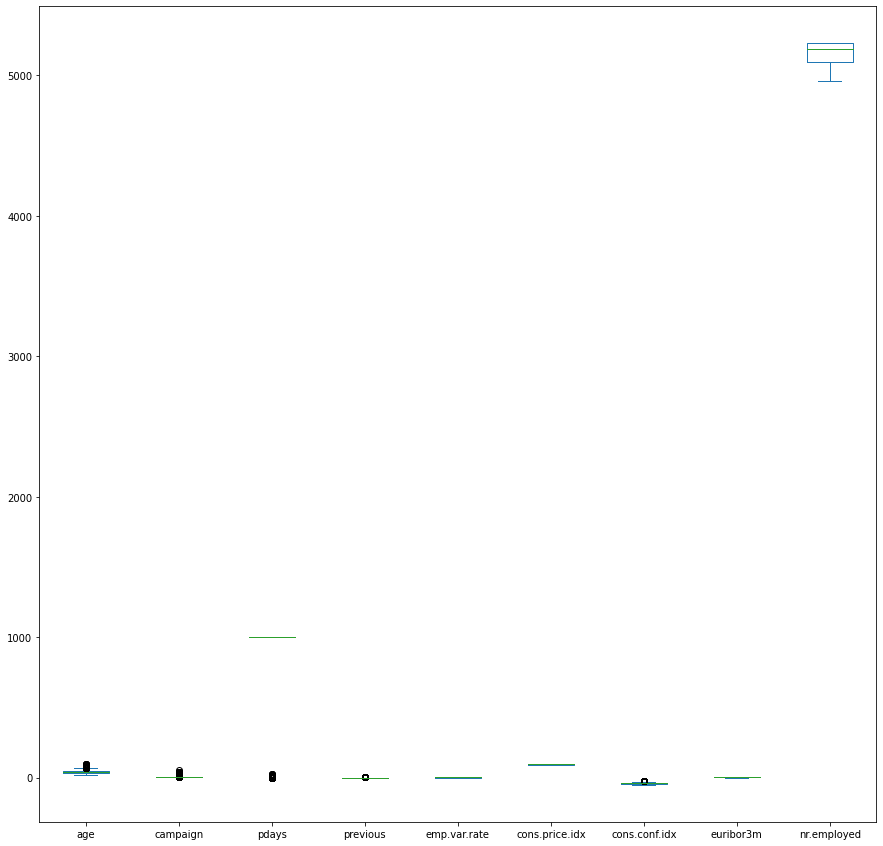

In [9]:
df.plot(kind='box', figsize=(15,15))

We can't see much here due to pdays and nr.employed. Let's see how the viz view without them

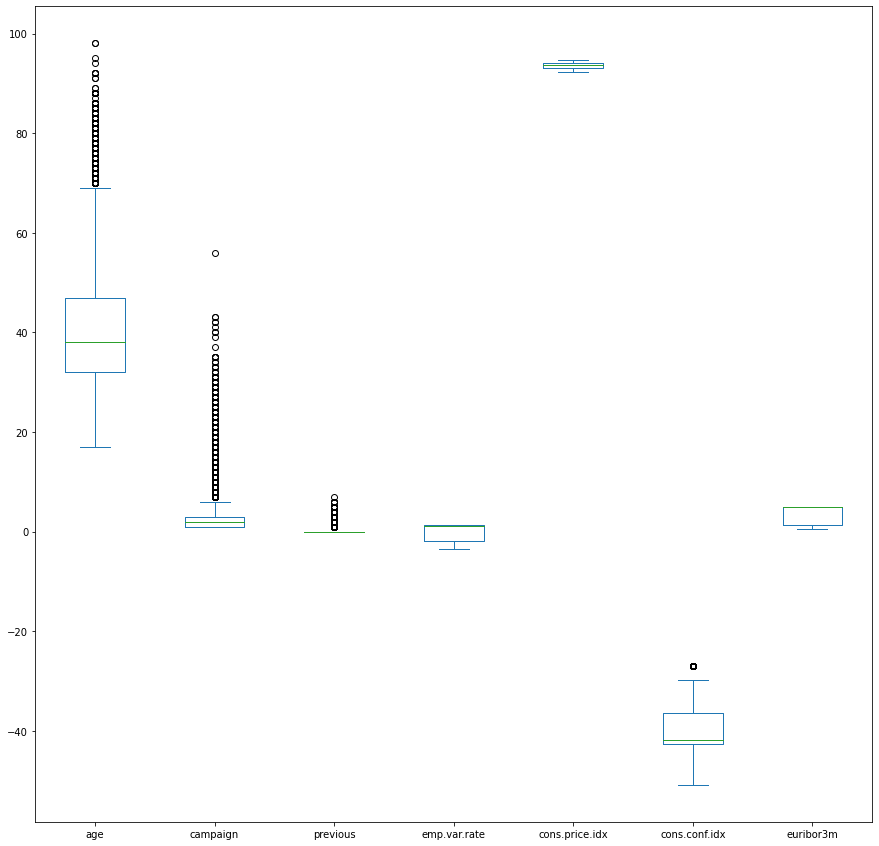

In [10]:
df.drop(columns=['pdays', 'nr.employed']).plot(kind='box', figsize=(15,15))

A few notes regarding the visualization and describe:
1. We know that pdays 999 is code for no contact and yet it fills most of the data. Winsorizer will only "caps" the data at 999, so that's not quite the solution

2. At least 75% of the "previous" column contain 0 values, but the other numbers might have useful information so we don't do anything with this column

3. As such, our decision is to not doing any outlier handling to keep this piece of information

4. We'll use the MinMaxScaler to preprocess all numeric model

## Train-Test-Split + Pipeline Definition

In [11]:
X = df.drop(columns='y')
y = df['y']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

After we get the training data, we'll split into numerical and categorical:

In [14]:
bank_num_tr = X_train.select_dtypes(include=[np.number])
bank_cat_tr = X_train.drop(columns=bank_num_tr.columns.tolist())


Defining the numerical pipeline:

In [13]:
num_pipeline = Pipeline([
              ('mmax_scaler', MinMaxScaler())
])

In defining categorical pipeline, we should consider what will the pipeline do when it detect new value on test data that weren't on train data. 

On our One Hot Encoder, we'll ignore that value, making the whole label 0

In [50]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

On our Ordinal Encoder, we'll encode the custom value of 1 + highest number of unique in a category

In [15]:
for col in bank_cat_tr:
    print(f'{col}: ', bank_cat_tr[col].nunique())
le = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = 13)

job:  12
marital:  4
education:  8
default:  3
housing:  3
loan:  3
contact:  2
month:  10
day_of_week:  5
poutcome:  3


Next we build the full pipeline with numerical and categorical data combined

In [17]:
num_attribs = list(bank_num_tr)
cat_attribs = list(bank_cat_tr)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", ohe, cat_attribs),
    ])
#X_train_prepared = full_pipeline.fit_transform(X_train)

We define our f1 scorer with modified positive label ("yes" instead of 1) here

In [19]:
f1_scorer = make_scorer(f1_score, pos_label="yes")

In our analysis of score, we wanted to minimize the "yes" that is predicted as "no", as we'll lose our potential customers. That means aside from f1-score, we focus on getting the highest recall on "yes"

For all models, we wanted to compare using one hot encoder and ordinal encoder to see the if all models should be using one-hot-encoder, and the time tradeoff on each model

For the 2nd parameter tuning, we will be using:
1. Logistic Regression: C = 1 or 10
2. SVM Classifier: C = 1 or 10
3. Decision Tree Classifier: criterion = 'gini' or 'entropy'
4. Random Forest Classifier: criterion = 'gini' or 'entropy'
5. kNN Classifier: n_neighbors = 3 or 5
6. Naive Bayes Classifier: var_smoothing = 1e-8 or 1e-09
7. LightGBM: n_estimators = 50 or 200

## 1. Logistic Regression

In [20]:
%%time
lgc_pipeline = Pipeline([("pipe", full_pipeline),
                         ("lgc", LogisticRegression(max_iter=10000, random_state=42))])

param_grid_lgc = [
    {
      'pipe__cat':[ohe,le],
      'lgc__C': [1, 10]
    }]

grid_lgc = GridSearchCV(lgc_pipeline, param_grid_lgc, cv=5, error_score='raise', 
                        scoring = f1_scorer, return_train_score = True, n_jobs=-1)
grid_lgc.fit(X_train, y_train)

CPU times: user 4.83 s, sys: 1.61 s, total: 6.44 s
Wall time: 49.1 s


In [21]:
lgc_res = pd.DataFrame(grid_lgc.cv_results_)
lgc_res[['mean_fit_time', 'params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by=['rank_test_score'])

,mean_fit_time,params,mean_test_score,std_test_score,rank_test_score
2,4.533694,"{'lgc__C': 10, 'pipe__cat': OneHotEncoder(hand...",0.343402,0.012265,1
0,3.300035,"{'lgc__C': 1, 'pipe__cat': OneHotEncoder(handl...",0.341777,0.010646,2
3,1.857729,"{'lgc__C': 10, 'pipe__cat': OrdinalEncoder(han...",0.340420,0.015183,3
1,3.248996,"{'lgc__C': 1, 'pipe__cat': OrdinalEncoder(hand...",0.335665,0.014097,4


Our logistic regression models performance are almost the same, with C=10 and using OneHotEncoder worked the best. The time used to perform the OneHotEncoder is the longest, but it's still less than 10 seconds in average

Our logistic regression models performance are almost the same, with C=10 and using OneHotEncoder worked the best. The time used to perform the OneHotEncoder is the longest, but it took only seconds 

In [22]:
y_pred = grid_lgc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.91      0.98      0.94      7303
         yes       0.64      0.21      0.32       935

    accuracy                           0.90      8238
   macro avg       0.77      0.60      0.63      8238
weighted avg       0.88      0.90      0.87      8238



This model performs well in predicting "no" label, but performs poorly in "yes". The recall for "yes" label is only 0.21. Overall f1 macro score for this model is 0.63

##2. Support Vector Machine

In [35]:
%%time
svc_pipeline = Pipeline([("pipe", full_pipeline),
                         ("svc", SVC(random_state=42))])

param_grid_svc = [
    {
      'pipe__cat':[ohe,le],
      'svc__C': [1, 10]
    }]

grid_svc = GridSearchCV(svc_pipeline, param_grid_svc, cv=5, error_score='raise', 
                        scoring = f1_scorer, return_train_score = True, n_jobs=-1)
grid_svc.fit(X_train, y_train)

CPU times: user 4min 4s, sys: 1.47 s, total: 4min 6s
Wall time: 23min 52s


In [45]:
svc_res = pd.DataFrame(grid_svc.cv_results_)
svc_res[['mean_fit_time', 'param_svc__C', 'params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by=['rank_test_score'])

,mean_fit_time,param_svc__C,params,mean_test_score,std_test_score,rank_test_score
1,127.473131,10,{'pipe__cat': OneHotEncoder(handle_unknown='ig...,0.369074,0.010655,1
2,38.414354,1,{'pipe__cat': OrdinalEncoder(handle_unknown='u...,0.316526,0.013889,2
3,83.503054,10,{'pipe__cat': OrdinalEncoder(handle_unknown='u...,0.316299,0.014332,3
0,77.600418,1,{'pipe__cat': OneHotEncoder(handle_unknown='ig...,0.303187,0.016700,4


Our SVM classifier model performance are best in using OneHotEncoder and C=10, but the time tradeoff is big with 127 seconds in average

In [36]:
%%time
y_pred = grid_svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.91      0.98      0.94      7303
         yes       0.60      0.26      0.36       935

    accuracy                           0.90      8238
   macro avg       0.76      0.62      0.65      8238
weighted avg       0.88      0.90      0.88      8238

CPU times: user 9.46 s, sys: 17.6 ms, total: 9.48 s
Wall time: 9.41 s


SVM classifier performs well in predicting "no", but suffers the same problem in predicting "yes". The recall for "yes" is only 0.26. Overall, the f1-macro score for this model is 0.65 


##3. Decision Tree Classifier

In [23]:
%%time
dtc_pipeline = Pipeline([("pipe", full_pipeline),
                         ("dtc", DecisionTreeClassifier(random_state = 42))])

param_grid_dtc = [
    {
      'pipe__cat':[ohe,le],
      'dtc__criterion': ['gini', 'entropy']
    }]

grid_dtc = GridSearchCV(dtc_pipeline, param_grid_dtc, cv=5, error_score='raise', 
                        scoring = f1_scorer, return_train_score = True, n_jobs=-1)
grid_dtc.fit(X_train, y_train)

CPU times: user 1.21 s, sys: 52.4 ms, total: 1.26 s
Wall time: 14.6 s


In [38]:
dtc_res = pd.DataFrame(grid_dtc.cv_results_)
dtc_res[['mean_fit_time', 'params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by=['rank_test_score'])

,mean_fit_time,params,mean_test_score,std_test_score,rank_test_score
3,0.425420,"{'dtc__criterion': 'entropy', 'pipe__cat': Ord...",0.334381,0.006017,1
2,0.640882,"{'dtc__criterion': 'entropy', 'pipe__cat': One...",0.334048,0.009375,2
1,0.441843,"{'dtc__criterion': 'gini', 'pipe__cat': Ordina...",0.331507,0.010936,3
0,0.697081,"{'dtc__criterion': 'gini', 'pipe__cat': OneHot...",0.330708,0.013463,4


On our first tree model, the Decision Tree, the performance are almost the same as well, with using entropy criterion and Ordinal Encoder being the highest in average score and fastest in time 


In [24]:
%%time
y_pred = grid_dtc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.92      0.90      0.91      7303
         yes       0.32      0.36      0.34       935

    accuracy                           0.84      8238
   macro avg       0.62      0.63      0.62      8238
weighted avg       0.85      0.84      0.85      8238

CPU times: user 349 ms, sys: 1.69 ms, total: 351 ms
Wall time: 353 ms


Decision Tree performs well in predicting "no", and just like before, performs poorly in predicting "yes". The recall for "yes" here is 0.36. There is one interesting result here where the precision on this model is also bad here. Overall, the f1-macro score for this model is 0.62 


## 4. Random Forest Classifier

In [25]:
%%time
rfc_pipeline = Pipeline([("pipe", full_pipeline),
                         ("rfc", RandomForestClassifier(random_state = 42))])

param_grid_rfc = [
    {
      'pipe__cat':[ohe,le],
      'rfc__criterion': ['gini', 'entropy']
    }]

grid_rfc = GridSearchCV(rfc_pipeline, param_grid_rfc, cv=5, error_score='raise', 
                        scoring = f1_scorer, return_train_score = True, n_jobs=-1)
grid_rfc.fit(X_train, y_train)

CPU times: user 5.04 s, sys: 176 ms, total: 5.22 s
Wall time: 1min 20s


In [48]:
rfc_res = pd.DataFrame(grid_rfc.cv_results_)
rfc_res[['mean_fit_time', 'param_rfc__criterion', 'params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by=['rank_test_score'])

,mean_fit_time,param_rfc__criterion,params,mean_test_score,std_test_score,rank_test_score
3,4.671516,entropy,{'pipe__cat': OrdinalEncoder(handle_unknown='u...,0.394215,0.008985,1
2,4.147800,gini,{'pipe__cat': OrdinalEncoder(handle_unknown='u...,0.393680,0.009824,2
1,5.210823,entropy,{'pipe__cat': OneHotEncoder(handle_unknown='ig...,0.386981,0.018669,3
0,7.882596,gini,{'pipe__cat': OneHotEncoder(handle_unknown='ig...,0.386001,0.014163,4


Random Forest result in Grid Search is better in Ordinal Encoder than OneHot, both in score and time. The best performance is using entropy criterion and Ordinal Encoder

In [26]:
%%time
y_pred = grid_rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.92      0.97      0.94      7303
         yes       0.55      0.31      0.40       935

    accuracy                           0.89      8238
   macro avg       0.73      0.64      0.67      8238
weighted avg       0.87      0.89      0.88      8238

CPU times: user 568 ms, sys: 0 ns, total: 568 ms
Wall time: 569 ms


This model performs well in predicting "no", and performs poorly in predicting "yes". The recall for "yes" here is 0.31, and the f1-macro score is 0.67

## 5. kNN Classifier

In [27]:
%%time
knc_pipeline = Pipeline([("pipe", full_pipeline),
                         ("knc", KNeighborsClassifier())])

param_grid_knc = [
    {
      'pipe__cat':[ohe,le],
      'knc__n_neighbors': [3, 5]
    }]

grid_knc = GridSearchCV(knc_pipeline, param_grid_knc, cv=5, error_score='raise', 
                        scoring = f1_scorer, return_train_score = True, n_jobs=-1)
grid_knc.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU times: user 3.03 s, sys: 440 ms, total: 3.47 s
Wall time: 4min 42s


In [40]:
knc_res = pd.DataFrame(grid_knc.cv_results_)
knc_res[['mean_fit_time', 'params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by=['rank_test_score'])

,mean_fit_time,params,mean_test_score,std_test_score,rank_test_score
0,0.242354,"{'knc__n_neighbors': 3, 'pipe__cat': OneHotEnc...",0.328705,0.008393,1
2,0.255809,"{'knc__n_neighbors': 5, 'pipe__cat': OneHotEnc...",0.315445,0.010435,2
1,0.239855,"{'knc__n_neighbors': 3, 'pipe__cat': OrdinalEn...",0.304161,0.018703,3
3,0.236693,"{'knc__n_neighbors': 5, 'pipe__cat': OrdinalEn...",0.281918,0.013397,4


In our kNN models, OneHotEncoder performs better than Ordinal Encoder in terms of score, while the time is almost the same for all. The best performance in terms of score is using 3 n-neighbors and OneHotEncoder

In [28]:
%%time
y_pred = grid_knc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.91      0.96      0.93      7303
         yes       0.44      0.26      0.33       935

    accuracy                           0.88      8238
   macro avg       0.67      0.61      0.63      8238
weighted avg       0.86      0.88      0.86      8238

CPU times: user 5.72 s, sys: 1.18 s, total: 6.91 s
Wall time: 5.32 s


The model is the same like the others, performing well in predicting "no" but performing bad in performing "yes". The recall for "yes" is 0.26 and our overall f1-macro score is 0.63

## 6. Naive Bayes Classifier

In [29]:
%%time
nbc_pipeline = Pipeline([("pipe", full_pipeline),
                         ("nbc", GaussianNB())])

param_grid_nbc = [
    {
      'pipe__cat':[ohe,le],
      'nbc__var_smoothing': [1e-9, 1e-8]
    }]

grid_nbc = GridSearchCV(nbc_pipeline, param_grid_nbc, cv=5, error_score='raise', 
                        scoring = f1_scorer, return_train_score = True, n_jobs=-1)
grid_nbc.fit(X_train, y_train)

CPU times: user 1.09 s, sys: 55 ms, total: 1.15 s
Wall time: 11.4 s


In [41]:
nbc_res = pd.DataFrame(grid_nbc.cv_results_)
nbc_res[['mean_fit_time', 'params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by=['rank_test_score'])

,mean_fit_time,params,mean_test_score,std_test_score,rank_test_score
1,0.275228,"{'nbc__var_smoothing': 1e-09, 'pipe__cat': Ord...",0.415307,0.014387,1
3,0.265627,"{'nbc__var_smoothing': 1e-08, 'pipe__cat': Ord...",0.415307,0.014387,1
2,0.326726,"{'nbc__var_smoothing': 1e-08, 'pipe__cat': One...",0.412587,0.012360,3
0,0.324541,"{'nbc__var_smoothing': 1e-09, 'pipe__cat': One...",0.406967,0.010445,4


Our Naive Bayes performs almost the same in terms of time and score, with Ordinal Encoder and var smoothing of 1e-09 and 1e-08 being the best performance.

In [31]:
%%time
y_pred = grid_nbc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.93      0.87      0.90      7303
         yes       0.34      0.50      0.41       935

    accuracy                           0.83      8238
   macro avg       0.64      0.69      0.65      8238
weighted avg       0.86      0.83      0.85      8238

CPU times: user 288 ms, sys: 4.76 ms, total: 292 ms
Wall time: 293 ms


We have interesting result where our recall for "yes" here scores 0.5, although the precision performs worse here. Our overall f1-macro score here is 0.65

##7. LightGBM Classifier

In [32]:
%%time
lgb_pipeline = Pipeline([("pipe", full_pipeline),
                         ("lgb", LGBMClassifier(random_state = 42))])

param_grid_lgb = [
    {
      'pipe__cat':[ohe,le],
      'lgb__n_estimators': [50, 200]
    }]

grid_lgb = GridSearchCV(lgb_pipeline, param_grid_lgb, cv=5, error_score='raise', 
                        scoring = f1_scorer, return_train_score = True, n_jobs=-1)
grid_lgb.fit(X_train, y_train)

CPU times: user 2.83 s, sys: 106 ms, total: 2.94 s
Wall time: 24.1 s


In [42]:
lgb_res = pd.DataFrame(grid_lgb.cv_results_)
lgb_res[['mean_fit_time', 'params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by=['rank_test_score'])

,mean_fit_time,params,mean_test_score,std_test_score,rank_test_score
3,1.478577,"{'lgb__n_estimators': 200, 'pipe__cat': Ordina...",0.396993,0.015956,1
2,1.528691,"{'lgb__n_estimators': 200, 'pipe__cat': OneHot...",0.395922,0.011502,2
1,0.660449,"{'lgb__n_estimators': 50, 'pipe__cat': Ordinal...",0.383314,0.010959,3
0,0.718246,"{'lgb__n_estimators': 50, 'pipe__cat': OneHotE...",0.382144,0.009120,4


For our LightGBM classifier, the performance is almost the same for Ordinal Encoder and OneHotEncoder in terms of score and time. The best parameter for LightGBM here is using 200 estimators and using Ordinal Encoder

In [34]:
%%time
y_pred = grid_lgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.91      0.98      0.94      7303
         yes       0.61      0.27      0.37       935

    accuracy                           0.90      8238
   macro avg       0.76      0.62      0.66      8238
weighted avg       0.88      0.90      0.88      8238

CPU times: user 460 ms, sys: 3.93 ms, total: 464 ms
Wall time: 405 ms


The prediction result is nothing new, good in predicting "no" and bad at predicting "yes". The recall for "yes" here is 0.27 and the overall f1-macro score is 0.66

## Model Conclusion

1. Our model generally predicts worse in "yes" label. Outlier handling should not be needed in tree-based models (DTC, RFC, LGBM), yet they also performs poorly, so imbalanced dataset and missing-value handling might be the cause here
2. Based on the average F1-macro, the best performing models are Random Forest, continued by LightGBM, NaiveBayes, SVM, kNN, Logistic Regression, and finally Decision Tree
3. Based on the recall values on "yes", the best performing models are Naive Bayes, continued by Decision Tree, Random Forest, LightGBM, kNN, SVM, and finally Logistic Regression
4. SVM take *way* longer than the rest of the model in training models
5. Generally, using OrdinalEncoder would work faster than the OneHotEncoder, and time tradeoff felt huge in using SVM. In all tree-based model and Naive Bayes, Ordinal Encoder also performs better score-wise



## Model Inference

We'll try to input the data into our models and to infer the input and the result. As noted before, the model assumed there's no 'duration' data

In [52]:
data_try = X_test[-1:]
data_try

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
1871,59,admin.,married,university.degree,no,yes,no,telephone,may,fri,2,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0


Here, there's a person whom:
1. Aged 59
2. Have a job as administrator
3. Married
4. Have university degree (presumably bachelor)
5. Have no credit in default
6. Have a housing loan
7. Have personal loan
8. Have been contacted via telephone by campaigner
9. Last contacted on Friday in May,
10. Have been contacted at least twice by campaigner in this campaign 
11. Have never been contacted in previous campaign, as such, there's no historic outcome of this campaign

The rest of the data is social context

Let's see how each of our model predicts whether this person will subscribe a term deposit or not

In [53]:
print(f'Logistic Regression: {grid_lgc.predict(data_try)}')
print(f'SVM: {grid_svc.predict(data_try)}')
print(f'Decision Tree: {grid_dtc.predict(data_try)}')
print(f'Random Forest: {grid_rfc.predict(data_try)}')
print(f'kNN Classifier: {grid_knc.predict(data_try)}')
print(f'Naive Bayes Classifier: {grid_nbc.predict(data_try)}')
print(f'LightGBM: {grid_lgb.predict(data_try)}')

Logistic Regression: ['no']
SVM: ['no']
Decision Tree: ['yes']
Random Forest: ['no']
kNN Classifier: ['no']
Naive Bayes Classifier: ['no']
LightGBM: ['no']


Only Decision Tree predict that this person subscribe a term deposit, the rest says no

## General Conclusion

1. This data have imbalanced dataset on target variables
2. There are many people in this dataset whom have not been contacted in the previous campaign 
3. In terms of maximizing recall on "Yes" context, we do not suggest to use these model yet to be put in deployment, as all of them are at most 50% in recall.
4. But, in terms of maximizing the overall correct result, our top 3 based on F1-macro: Random Forest, LightGBM, and Naive Bayes might be a good start on deployment
